In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from datetime import datetime

In [2]:
df_full = pd.read_pickle("./data_frame_full_2021-03-12.pickle")

In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Columns: 107 entries, backers_count to deadline_month
dtypes: bool(5), datetime64[ns](3), float64(18), int64(16), object(65)
memory usage: 163.8+ MB


In [4]:
df_small = pd.read_pickle("./data_frame_small_2021-03-12.pickle")

In [5]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209222 entries, 0 to 209221
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   backers_count          209222 non-null  int64         
 1   blurb                  209214 non-null  object        
 2   country                209222 non-null  object        
 3   created_at             209222 non-null  int64         
 4   currency               209222 non-null  object        
 5   deadline               209222 non-null  int64         
 6   disable_communication  209222 non-null  bool          
 7   goal                   209222 non-null  float64       
 8   launched_at            209222 non-null  int64         
 9   name                   209222 non-null  object        
 10  staff_pick             209222 non-null  bool          
 11  state                  209222 non-null  object        
 12  usd_pledged            209222 non-null  floa

# Target classes and balance

In [6]:
vals = df_full['state'].value_counts()
vals

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [7]:
print('Portion of success: {:.2f}%'.format( 100*vals[0] / (vals[0]+vals[1]) ))
print('Portion of fail:    {:.2f}%'.format( 100*vals[1] / (vals[0]+vals[1]) ))

Portion of success: 60.97%
Portion of fail:    39.03%


We have a sligth imbalance.

# Date time

In [8]:
df_full['launched_at'].describe(datetime_is_numeric=True)

count    2.092220e+05
mean     1.460206e+09
std      6.309029e+07
min      1.240603e+09
25%      1.417639e+09
50%      1.461924e+09
75%      1.516694e+09
max      1.552537e+09
Name: launched_at, dtype: float64

## Country

In [9]:
ratio = lambda x: 100*round(x.value_counts()['successful'] / (x.value_counts()['successful'] + x.value_counts()['failed'] + x.value_counts()['canceled']), 4)

In [10]:
success_per_country = pd.pivot_table(df_full, index='country', values='state', aggfunc=ratio).rename(columns={'state':'success_ratio'}).sort_values(by='success_ratio', ascending=False)
success_per_country

,success_ratio
country,
HK,76.70
JP,73.19
LU,66.07
SG,64.20
GB,62.69
US,59.49
DK,57.76
NZ,55.53
CA,55.10


<AxesSubplot:xlabel='success_ratio', ylabel='country'>

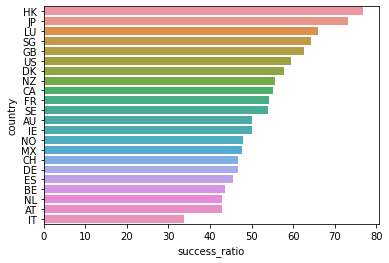

In [11]:
sns.barplot(data=success_per_country.reset_index(), y='country', x='success_ratio')

# Pledged

## Pledged amount - Exchange rate

In [12]:
currency_delta = df_full['converted_pledged_amount'].astype(float) - df_full['usd_pledged'] * df_full['static_usd_rate']
currency_delta.describe()

count    2.092220e+05
mean    -8.551623e+01
std      1.270609e+04
min     -1.771501e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.330207e+05
dtype: float64

In [13]:
currency_cols = ['country', 'converted_pledged_amount', 'currency', 'currency_symbol', 'fx_rate', 'usd_pledged', 'usd_type']
df_full[currency_delta > 900][currency_cols].head(10)

,country,converted_pledged_amount,currency,currency_symbol,fx_rate,usd_pledged,usd_type
56,SG,19699,SGD,$,0.737115,19338.586040,international
83,NO,2182,NOK,kr,0.115720,2088.859902,domestic
87,SE,4340,SEK,kr,0.106663,4417.467480,domestic
94,NO,4649,NOK,kr,0.115720,4967.397210,international
113,SE,62874,SEK,kr,0.106663,63854.911570,domestic
145,MX,2107,MXN,$,0.051662,2112.931235,international
154,SE,5571,SEK,kr,0.106663,5507.784406,international
165,MX,2061,MXN,$,0.051662,2051.492031,domestic
275,CA,41677,CAD,$,0.748258,41786.790700,domestic
300,SG,12189,SGD,$,0.737115,12090.014060,domestic


## Plegded - over the years

<AxesSubplot:xlabel='launched_at_year,launched_at_month'>

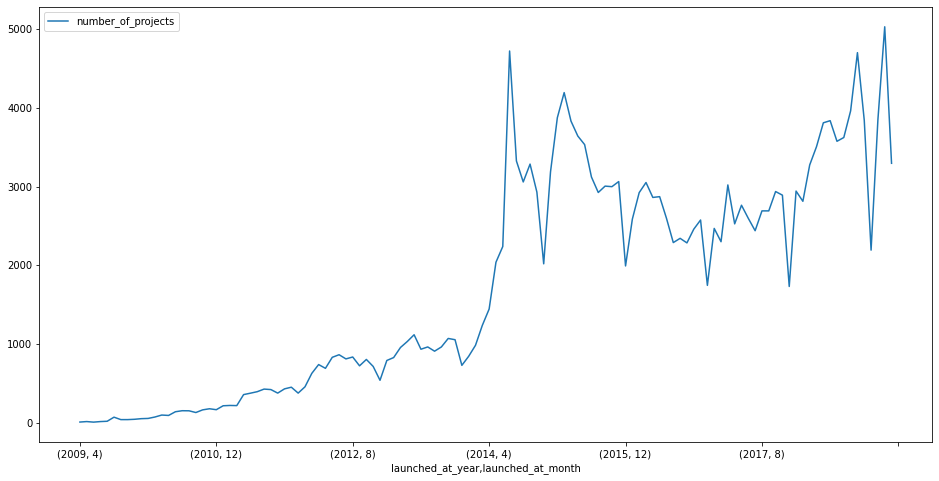

In [14]:
number_per_month = pd.pivot_table(df_small, index=['launched_at_year', 'launched_at_month'], values='usd_pledged', aggfunc=len).rename(columns={'usd_pledged':'number_of_projects'})
number_per_month.plot(figsize=(16,8))

In [16]:
number_per_month

number_of_projects
launched_at_year launched_at_month                    
2009             4                                 6.0
                 5                                12.0
                 6                                 5.0
                 7                                12.0
                 8                                16.0
...                                                ...
2018             11                             3843.0
                 12                             2192.0
2019             1                              3850.0
                 2                              5032.0
                 3                              3296.0

[120 rows x 1 columns]

<AxesSubplot:xlabel='launched_at_year,launched_at_month'>

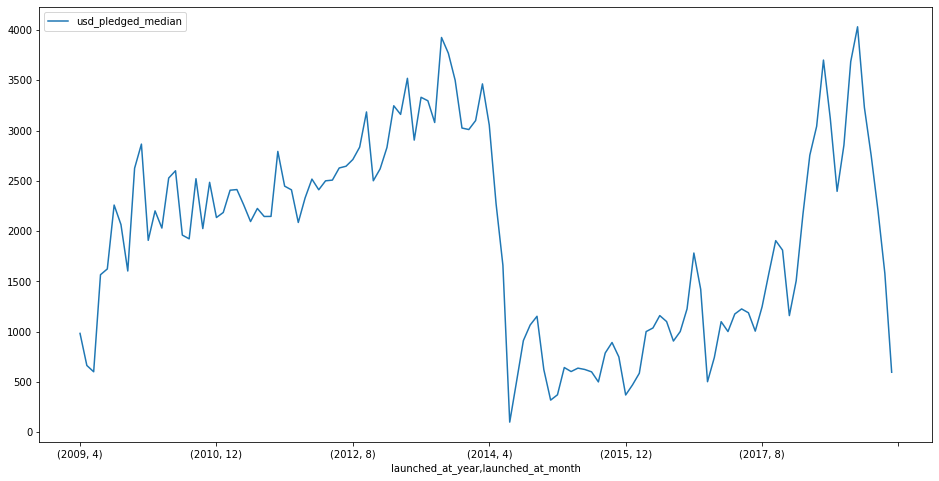

In [17]:
usd_pledged_median_per_month = pd.pivot_table(df_small, index=['launched_at_year', 'launched_at_month'], values='usd_pledged', aggfunc=pd.Series.median).rename(columns={'usd_pledged':'usd_pledged_median'})
usd_pledged_median_per_month.plot(figsize=(16,8))

<AxesSubplot:xlabel='launched_at_year,launched_at_month'>

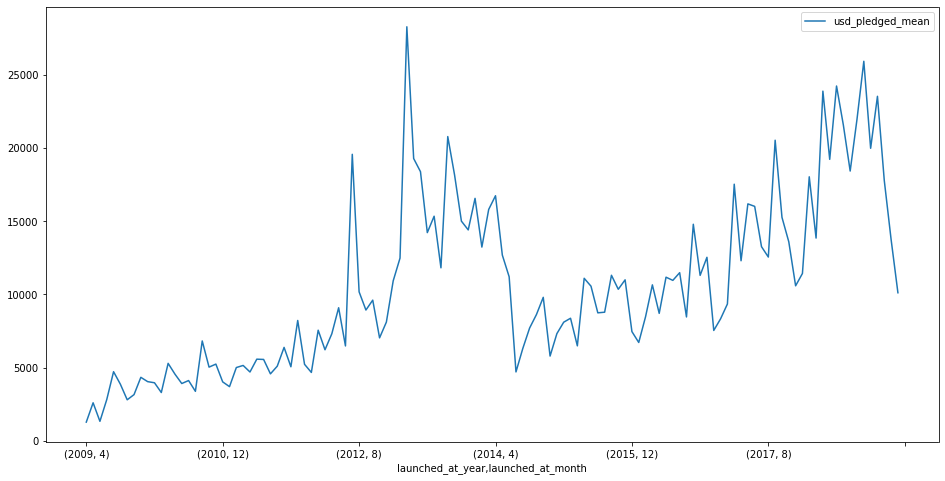

In [18]:
usd_pledged_mean_per_month = pd.pivot_table(df_full, index=['launched_at_year', 'launched_at_month'], values='usd_pledged', aggfunc=pd.Series.mean).rename(columns={'usd_pledged':'usd_pledged_mean'})
usd_pledged_mean_per_month.plot(figsize=(16,8))

In [19]:
df_small.query("state == 'failed'")['usd_pledged'].describe()

count     75199.000000
mean       1087.368352
std        5656.864120
min           0.000000
25%           1.000000
50%          55.830230
75%         440.000000
max      607628.380000
Name: usd_pledged, dtype: float64

## Pledged - Categories

In [25]:
filter_col = [col for col in df_full if col.startswith('category')]
df_full[filter_col].query('category_id == 16').head()

,category_id,category_name,category_slug,category_position,category_parent_id,category_color,category_urls.web.discover
614,16,Technology,technology,14,NaN,6526716,http://www.kickstarter.com/discover/categories...
743,16,Technology,technology,14,NaN,6526716,http://www.kickstarter.com/discover/categories...
770,16,Technology,technology,14,NaN,6526716,http://www.kickstarter.com/discover/categories...
999,16,Technology,technology,14,NaN,6526716,http://www.kickstarter.com/discover/categories...
1170,16,Technology,technology,14,NaN,6526716,http://www.kickstarter.com/discover/categories...


In [22]:
usd_pledged_mean_per_category= pd.pivot_table(df_small, index=['launched_at_year', 'launched_at_month'], columns='category_parent_name', values='usd_pledged', aggfunc=pd.Series.mean).rename(columns={'usd_pledged':'usd_pledged_mean'})


In [23]:
usd_pledged_mean_per_category

category_parent_name                        Art       Comics       Crafts  \
launched_at_year launched_at_month                                          
2009             4                    35.000000          NaN          NaN   
                 5                  1011.833333          NaN          NaN   
                 6                  2083.505000          NaN          NaN   
                 7                  1781.041667          NaN          NaN   
                 8                  8149.541429          NaN          NaN   
...                                         ...          ...          ...   
2018             11                 7938.193590  8932.034879  2929.750699   
                 12                 4272.928553  6458.814655  5212.962724   
2019             1                  5010.982057  8105.322479  2681.732412   
                 2                  3332.662801  6134.463642  2003.806807   
                 3                  1232.504844  7070.505524  2719.276064   

category_parent_name                      Dance        Design       Fashion  \
launched_at_year launched_at_month                                            
2009             4                          NaN     41.000000           NaN   
                 5                          NaN    340.000000           NaN   
                 6                          NaN           NaN           NaN   
                 7                          NaN    866.060000           NaN   
                 8                          NaN     25.000000           NaN   
...                                         ...           ...           ...   
2018             11                 5042.671969  40372.456882   5392.274765   
                 12                 2583.271821  63721.065589  12048.795624   
2019             1                  2990.888173  39166.438118   3894.348043   
                 2                  4155.348228  37032.844342   5368.645332   
                 3                   942.081616  11452.870039   4074.039246   

category_parent_name                Film & Video         Food         Games  \
launched_at_year launched_at_month                                            
2009             4                           NaN          NaN   2265.000000   
                 5                  10184.500000          NaN           NaN   
                 6                    370.000000          NaN           NaN   
                 7                   9610.000000          NaN           NaN   
                 8                    323.000000          NaN           NaN   
...                                          ...          ...           ...   
2018             11                  7673.820604  9821.582228  38630.781580   
                 12                  8057.222131  9361.215649  66170.530889   
2019             1                   6447.503249  5319.677233  50145.865363   
                 2                   5155.239410  7957.967712  29021.599055   
                 3                  51264.782715  3881.130371  12932.689563   

category_parent_name                 Journalism        Music   Photography  \
launched_at_year launched_at_month                                           
2009             4                  3329.000000          NaN           NaN   
                 5                  1090.500000  6374.195000           NaN   
                 6                  1500.000000          NaN           NaN   
                 7                          NaN          NaN           NaN   
                 8                  2942.876667  2601.000000           NaN   
...                                         ...          ...           ...   
2018             11                 6021.620692  6536.294271   6436.977901   
                 12                 2193.442608  6114.297147  14806.009310   
2019             1                  3625.721702  7054.490884   4615.073037   
                 2                   916.886673  4561.927641   8444.483107   
      

<AxesSubplot:xlabel='launched_at_year,launched_at_month'>

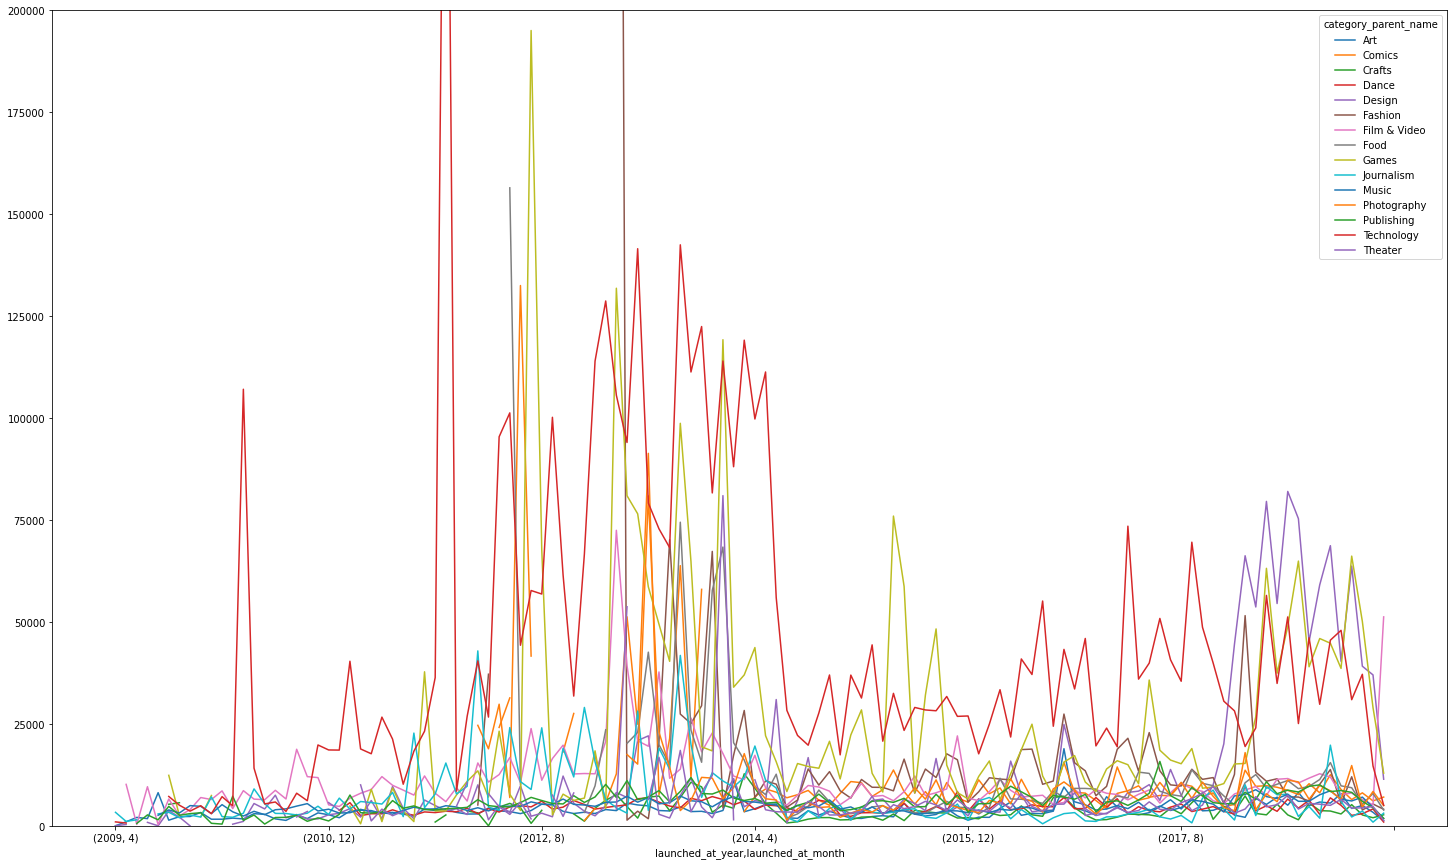

In [24]:
usd_pledged_mean_per_category.plot(figsize=(25,15), ylim=(0,200000))